In [54]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy.random as random
import scipy as sp
from scipy import stats
from scipy import integrate
from pandas import Series, DataFrame
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mlp
import matplotlib.pyplot as plt
import japanize_matplotlib
import math
from random import Random

from GLMM_With_Hamiltonian_Monte_Carlo import PoissonRegression_On_Bayes
from GLMM_With_Hamiltonian_Monte_Carlo import Leap_Flog, np_mode

%matplotlib inline
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def agg_data_for_unit():
    data_sets = pd.DataFrame()
    beacon_files = os.listdir('raw_data/')
    pos_files = os.listdir('POS_RAW_data/')

    beacon_files.sort()
    pos_files.sort()
    
    if beacon_files[0] == ".DS_Store":
        beacon_files.pop(0)

    if pos_files[0] == ".DS_Store":
        pos_files.pop(0)

    pos_files = list(map(lambda x: x[:14], pos_files))[::2]

    for beacon_file, pos_file in zip(beacon_files, pos_files):
        date_beacon = beacon_file[9:17]
        date_pos    = pos_file[6:14]

        if date_beacon != date_pos:
            continue
        else:
            date = date_beacon
        
        t_start = datetime.strptime(f'{date} 09:00', '%Y%m%d %H:%M').timestamp()
        t_end   = datetime.strptime(f'{date} 21:00', '%Y%m%d %H:%M').timestamp()
        rssi    = 70
        beacon_data = pd.read_csv(f"raw_data/{beacon_file}")
        pos_data1 = pd.read_csv(f"POS_RAW_data/{pos_file}_01.csv")
        pos_data2 = pd.read_csv(f"POS_RAW_data/{pos_file}_02.csv")

        pos_data1 = pos_data1[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data2 = pos_data2[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data  = pd.concat([pos_data1, pos_data2])

        pos_data[["単価", "数量", "合計金額"]] = pos_data[["単価", "数量", "合計金額"]].map(lambda x: int(x))
        pos_data = pos_data.groupby(["商品コード", "商品名称（または券名称）"]).sum()

        pos_data["単価"] = pos_data["合計金額"] / pos_data["数量"]
        pos_data["単価"] = pos_data["単価"].astype(int)

        beacon_data.columns = ["No.", "mac-address", "distance", "rssi", "random", "timestamp"]
        beacon_data = beacon_data[beacon_data["random"] == 1]
        beacon_data = beacon_data[beacon_data["timestamp"] >= t_start]
        beacon_data = beacon_data[beacon_data["timestamp"] <= t_end]
        beacon_data = beacon_data[beacon_data["rssi"] < rssi]
        beacon_data = beacon_data.drop_duplicates("mac-address")

        per_unit = pd.DataFrame(
            {
                "date":[date],
                "総ビーコン数": [len(beacon_data)],
                "総売上点数": [pos_data["数量"].sum()],
                "総売上": [pos_data["合計金額"].sum()],
            }
        )
        data_sets = pd.concat([data_sets, per_unit])

    return data_sets.reset_index(drop=True)

In [4]:
data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = PoissonRegression_On_Bayes(isGLMM=False, hamiltonian_ε=1e-2, hamiltonian_ite=100)
model.sampling(X_train, y_train, scale=2, iter_num=3000, visible_period=10)

#iterate 3000回  1m 52.0s

現在ite:0  保存サンプリング数:0
現在ite:10  保存サンプリング数:10
現在ite:20  保存サンプリング数:20
現在ite:30  保存サンプリング数:30
現在ite:40  保存サンプリング数:40
現在ite:50  保存サンプリング数:50
現在ite:60  保存サンプリング数:60
現在ite:70  保存サンプリング数:70
現在ite:80  保存サンプリング数:80
現在ite:90  保存サンプリング数:90
現在ite:100  保存サンプリング数:100
現在ite:110  保存サンプリング数:110
現在ite:120  保存サンプリング数:120
現在ite:130  保存サンプリング数:130
現在ite:140  保存サンプリング数:140
現在ite:150  保存サンプリング数:150
現在ite:160  保存サンプリング数:160
現在ite:170  保存サンプリング数:170
現在ite:180  保存サンプリング数:180
現在ite:190  保存サンプリング数:190
現在ite:200  保存サンプリング数:200
現在ite:210  保存サンプリング数:210
現在ite:220  保存サンプリング数:220
現在ite:230  保存サンプリング数:230
現在ite:240  保存サンプリング数:240
現在ite:250  保存サンプリング数:250
現在ite:260  保存サンプリング数:260
現在ite:270  保存サンプリング数:270
現在ite:280  保存サンプリング数:280
現在ite:290  保存サンプリング数:290
現在ite:300  保存サンプリング数:300
現在ite:310  保存サンプリング数:310
現在ite:320  保存サンプリング数:320
現在ite:330  保存サンプリング数:330
現在ite:340  保存サンプリング数:340
現在ite:350  保存サンプリング数:350
現在ite:360  保存サンプリング数:360
現在ite:370  保存サンプリング数:370
現在ite:380  保存サンプリング数:380
現在ite:390  保存サンプリング数:390
現在ite:400  保存サンプリング数:4

True

Statistics information
          mean      median      std      mode
alpha     0.14979   0.14917     0.06232     0.13502
alpha0    6.72972   6.72990     0.06699     6.73602



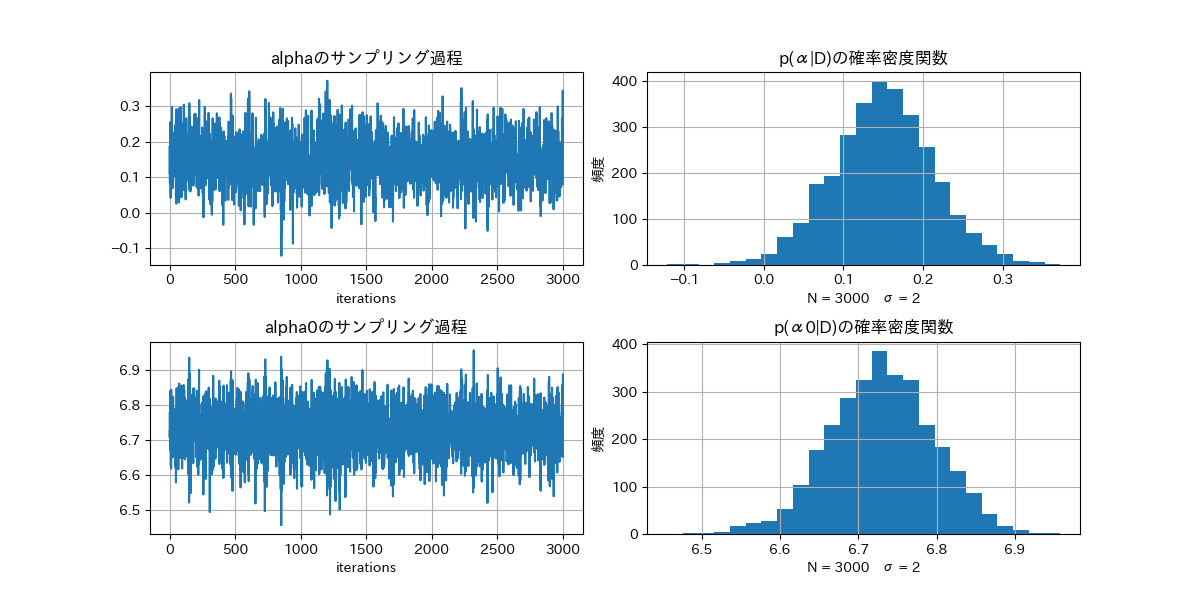

In [110]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(2,2,1)
plt.plot(np.arange(0, model.sampling_alpha.shape[0], 1), model.sampling_alpha)
plt.title("alphaのサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(2,2,2)
plt.hist(model.sampling_alpha[:, 0], bins=25)
plt.title("p(α|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_alpha.shape[0]}   σ = {2}")
plt.ylabel("頻度")
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(np.arange(0, model.sampling_alpha0.shape[0], 1), model.sampling_alpha0)
plt.title("alpha0のサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(2,2,4)
plt.hist(model.sampling_alpha0, bins=25)
plt.title("p(α0|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_alpha0.shape[0]}   σ = {2}")
plt.ylabel("頻度")
plt.grid(True)

print("Statistics information")
print("          mean      median      std      mode")
print("alpha     {:.5f}   {:.5f}     {:.5f}     {:.5f}".format(np.mean(model.sampling_alpha    ), np.median(model.sampling_alpha    ), np.std(model.sampling_alpha    ), np_mode(model.sampling_alpha )))
print("alpha0    {:.5f}   {:.5f}     {:.5f}     {:.5f}".format(np.mean(model.sampling_alpha0   ), np.median(model.sampling_alpha0   ), np.std(model.sampling_alpha0   ), np_mode(model.sampling_alpha0)))
print("")

In [10]:
data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = PoissonRegression_On_Bayes(isGLMM=True, hamiltonian_ε=1e-2, hamiltonian_ite=100)
model.sampling(X_train, y_train, scale=2, iter_num=3000, visible_period=10)

#iterate 3000回  531m 45.3s

現在ite:0  保存サンプリング数:0
現在ite:10  保存サンプリング数:10
現在ite:20  保存サンプリング数:20
現在ite:30  保存サンプリング数:30
現在ite:40  保存サンプリング数:40
現在ite:50  保存サンプリング数:50
現在ite:60  保存サンプリング数:60
現在ite:70  保存サンプリング数:70
現在ite:80  保存サンプリング数:80
現在ite:90  保存サンプリング数:90
現在ite:100  保存サンプリング数:100
現在ite:110  保存サンプリング数:110
現在ite:120  保存サンプリング数:120
現在ite:130  保存サンプリング数:130
現在ite:140  保存サンプリング数:140
現在ite:150  保存サンプリング数:150
現在ite:160  保存サンプリング数:160
現在ite:170  保存サンプリング数:170
現在ite:180  保存サンプリング数:180
現在ite:190  保存サンプリング数:190
現在ite:200  保存サンプリング数:200
現在ite:210  保存サンプリング数:210
現在ite:220  保存サンプリング数:220
現在ite:230  保存サンプリング数:230
現在ite:240  保存サンプリング数:240
現在ite:250  保存サンプリング数:250
現在ite:260  保存サンプリング数:260
現在ite:270  保存サンプリング数:270
現在ite:280  保存サンプリング数:280
現在ite:290  保存サンプリング数:290
現在ite:300  保存サンプリング数:300
現在ite:310  保存サンプリング数:310
現在ite:320  保存サンプリング数:320
現在ite:330  保存サンプリング数:330
現在ite:340  保存サンプリング数:340
現在ite:350  保存サンプリング数:350
現在ite:360  保存サンプリング数:360
現在ite:370  保存サンプリング数:370
現在ite:380  保存サンプリング数:380
現在ite:390  保存サンプリング数:390
現在ite:400  保存サンプリング数:4

/Users/h_nagino/work/一般線形回帰/To_Nagino2/C-united_カフェドクリエ京都四条店/GLMM_With_Hamiltonian_Monte_Carlo.py:202: RuntimeWarning: overflow encountered in exp
  λ_r  = λ * np.exp(r)
/Users/h_nagino/work/一般線形回帰/To_Nagino2/C-united_カフェドクリエ京都四条店/GLMM_With_Hamiltonian_Monte_Carlo.py:202: RuntimeWarning: overflow encountered in multiply
  λ_r  = λ * np.exp(r)
/opt/homebrew/lib/python3.12/site-packages/scipy/stats/_discrete_distns.py:962: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
/Users/h_nagino/work/一般線形回帰/To_Nagino2/C-united_カフェドクリエ京都四条店/GLMM_With_Hamiltonian_Monte_Carlo.py:208: RuntimeWarning: overflow encountered in exp
  λ_r  = λ * np.exp(r)
/Users/h_nagino/work/一般線形回帰/To_Nagino2/C-united_カフェドクリエ京都四条店/GLMM_With_Hamiltonian_Monte_Carlo.py:208: RuntimeWarning: overflow encountered in multiply
  λ_r  = λ * np.exp(r)
/Users/h_nagino/work/一般線形回帰/To_Nagino2/C-united_カフェドクリエ京都四条店/GLMM_With_Hamiltonian_Monte_Carlo.py:292: RuntimeWarning: over

現在ite:10  保存サンプリング数:10
現在ite:20  保存サンプリング数:20
現在ite:30  保存サンプリング数:30
現在ite:40  保存サンプリング数:40
現在ite:50  保存サンプリング数:50
現在ite:60  保存サンプリング数:60
現在ite:70  保存サンプリング数:70
現在ite:80  保存サンプリング数:80
現在ite:90  保存サンプリング数:90
現在ite:100  保存サンプリング数:100
現在ite:110  保存サンプリング数:110
現在ite:120  保存サンプリング数:120
現在ite:130  保存サンプリング数:130
現在ite:140  保存サンプリング数:140
現在ite:150  保存サンプリング数:150
現在ite:160  保存サンプリング数:160
現在ite:170  保存サンプリング数:170
現在ite:180  保存サンプリング数:180
現在ite:190  保存サンプリング数:190
現在ite:200  保存サンプリング数:200
現在ite:210  保存サンプリング数:210
現在ite:220  保存サンプリング数:220
現在ite:230  保存サンプリング数:230
現在ite:240  保存サンプリング数:240
現在ite:250  保存サンプリング数:250
現在ite:260  保存サンプリング数:260
現在ite:270  保存サンプリング数:270
現在ite:280  保存サンプリング数:280
現在ite:290  保存サンプリング数:290
現在ite:300  保存サンプリング数:300
現在ite:310  保存サンプリング数:310
現在ite:320  保存サンプリング数:320
現在ite:330  保存サンプリング数:330
現在ite:340  保存サンプリング数:340
現在ite:350  保存サンプリング数:350
現在ite:360  保存サンプリング数:360
現在ite:370  保存サンプリング数:370
現在ite:380  保存サンプリング数:380
現在ite:390  保存サンプリング数:390
現在ite:400  保存サンプリング数:400
現在ite:410  保存サンプリン

True

Statistics information
          mean      median      std      mode
alpha     0.14979   0.14917     0.06232     0.13502
alpha0    6.72972   6.72990     0.06699     6.73602
gauss_s   -1.07689   -1.17759     2.02269     -1.61082

quartiles
          2.5%    25%      50%      75%      97.5%
alpha     -0.12121 0.10985  0.14917  0.19074  0.37226
alpha0    6.45609 6.68553  6.72990  6.77390  6.95803
gauss_s   -8.99031 -2.33333  -1.17759  0.28730  3.38819


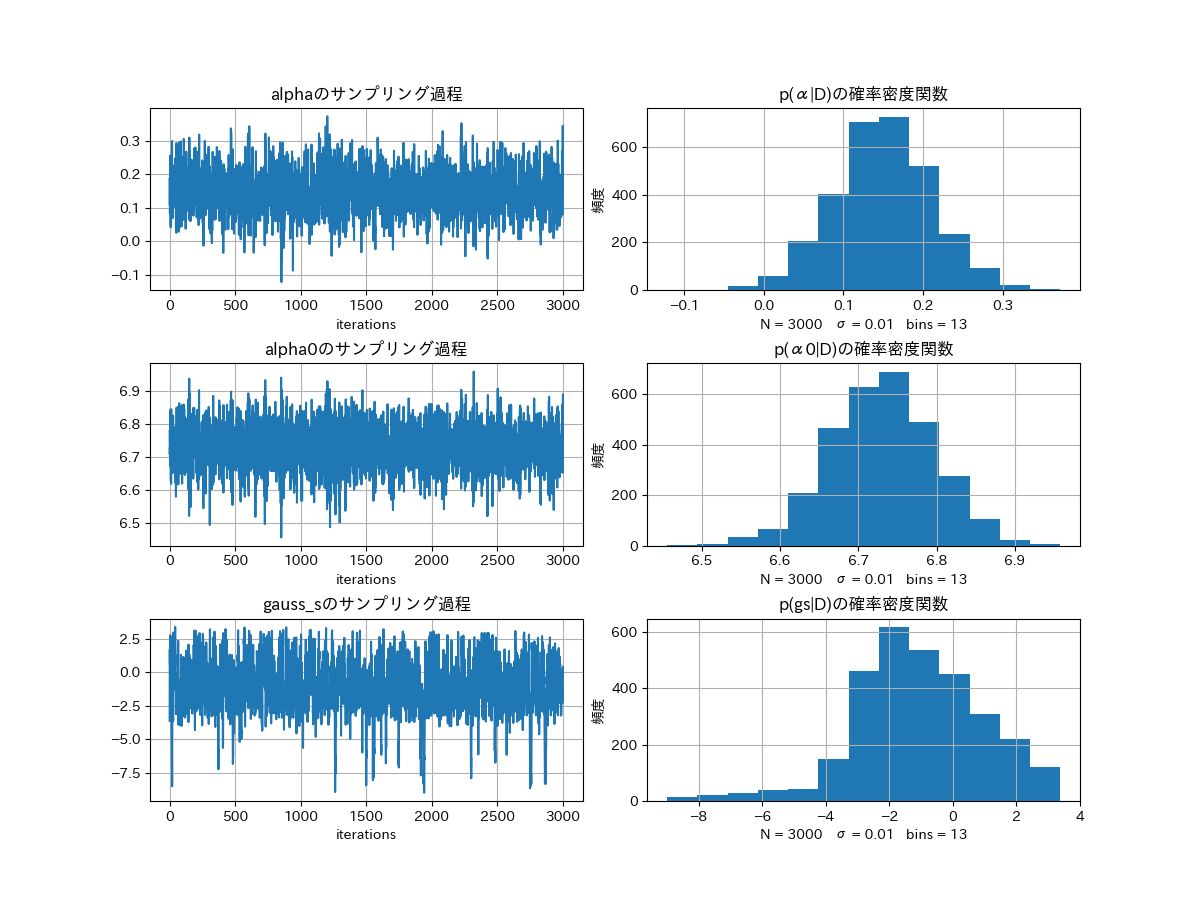

In [114]:
import math

plt.figure(figsize=(12, 9))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(3,2,1)
plt.plot(np.arange(0, model.sampling_alpha.shape[0], 1), model.sampling_alpha)
plt.title("alphaのサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(3,2,2)
bins = 1 + np.log2(len(model.sampling_alpha[:, 0]))
plt.hist(model.sampling_alpha[:, 0], bins=math.ceil(bins))
plt.title("p(α|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_alpha.shape[0]}   σ = {0.01}   bins = {math.ceil(bins)}")
plt.ylabel("頻度")
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(np.arange(0, model.sampling_alpha0.shape[0], 1), model.sampling_alpha0)
plt.title("alpha0のサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(3,2,4)
bins = 1 + np.log2(len(model.sampling_alpha0))
plt.hist(model.sampling_alpha0, bins=math.ceil(bins))
plt.title("p(α0|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_alpha0.shape[0]}   σ = {0.01}   bins = {math.ceil(bins)}")
plt.ylabel("頻度")
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(np.arange(0, model.sampling_gauss_r_σ.shape[0], 1), model.sampling_gauss_r_σ)
plt.title("gauss_sのサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(3,2,6)
bins = 1 + np.log2(len(model.sampling_gauss_r_σ))
plt.hist(model.sampling_gauss_r_σ, bins=math.ceil(bins))
plt.title("p(gs|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_gauss_r_σ.shape[0]}   σ = {0.01}   bins = {math.ceil(bins)}")
plt.ylabel("頻度")
plt.grid(True)

print("Statistics information")
print("          mean      median      std      mode")
print("alpha     {:.5f}   {:.5f}     {:.5f}     {:.5f}".format(np.mean(model.sampling_alpha    ), np.median(model.sampling_alpha    ), np.std(model.sampling_alpha    ), np_mode(model.sampling_alpha    )))
print("alpha0    {:.5f}   {:.5f}     {:.5f}     {:.5f}".format(np.mean(model.sampling_alpha0   ), np.median(model.sampling_alpha0   ), np.std(model.sampling_alpha0   ), np_mode(model.sampling_alpha0   )))
print("gauss_s   {:.5f}   {:.5f}     {:.5f}     {:.5f}".format(np.mean(model.sampling_gauss_r_σ), np.median(model.sampling_gauss_r_σ), np.std(model.sampling_gauss_r_σ), np_mode(model.sampling_gauss_r_σ)))
print("")

p_alpha   = np.percentile(model.sampling_alpha,     q=[0, 25, 50, 75, 100])
p_alpha0  = np.percentile(model.sampling_alpha0,    q=[0, 25, 50, 75, 100])
p_gauss_s = np.percentile(model.sampling_gauss_r_σ, q=[0, 25, 50, 75, 100])
print("quartiles")
print("          2.5%    25%      50%      75%      97.5%")
print("alpha     {:.5f} {:.5f}  {:.5f}  {:.5f}  {:.5f}".format(p_alpha[0],   p_alpha[1],   p_alpha[2],   p_alpha[3],   p_alpha[4]))
print("alpha0    {:.5f} {:.5f}  {:.5f}  {:.5f}  {:.5f}".format(p_alpha0[0],  p_alpha0[1],  p_alpha0[2],  p_alpha0[3],  p_alpha0[4]))
print("gauss_s   {:.5f} {:.5f}  {:.5f}  {:.5f}  {:.5f}".format(p_gauss_s[0], p_gauss_s[1], p_gauss_s[2], p_gauss_s[3], p_gauss_s[4]))

In [ ]:
def test(x):
    return x**2

def test_diff(x):
    return 2*x

tmp_position    = np.random.normal(loc=0, scale=1, size=1)
tmp_impetus     = np.random.normal(loc=0, scale=1, size=1)
tmp_hamiltonian = np.sum(test(tmp_position)) + np.sum(tmp_impetus ** 2) / 2

now_position, now_impetus = Leap_Flog(test_diff, tmp_position, tmp_impetus, ε=0.001, max_iterate=100000)
now_hamiltonian = np.sum(test(now_position)) + np.sum(now_impetus ** 2) / 2

print(tmp_hamiltonian)
print(now_hamiltonian)